In [ ]:
!python --version

Download data from tsinghua cloud


In [ ]:
# Download training_data
!wget -O training_data.zip https://cloud.tsinghua.edu.cn/f/7eece510dc784e70a083/?dl=1

# Unzip
!unzip training_data.zip -d ./

# Remove unecessary documents
%rm -r training_data/__MACOSX/
%rm training_data.zip

# Check final result
!ls training_data/

--2020-11-29 17:15:44--  https://cloud.tsinghua.edu.cn/f/7eece510dc784e70a083/?dl=1
Resolving cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)... 101.6.8.7
Connecting to cloud.tsinghua.edu.cn (cloud.tsinghua.edu.cn)|101.6.8.7|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cloud.tsinghua.edu.cn/seafhttp/files/b8afc4ed-8d0d-444e-8fc4-b776160408ce/training_data.zip [following]
--2020-11-29 17:15:45--  https://cloud.tsinghua.edu.cn/seafhttp/files/b8afc4ed-8d0d-444e-8fc4-b776160408ce/training_data.zip
Reusing existing connection to cloud.tsinghua.edu.cn:443.
HTTP request sent, awaiting response... 200 OK
Length: 928376700 (885M) [application/zip]
Saving to: ‘training_data.zip’

training_data.zip   100%[===================>] 885.37M  12.9MB/s    in 66s     

2020-11-29 17:16:51 (13.5 MB/s) - ‘training_data.zip’ saved [928376700/928376700]

Archive:  training_data.zip
   creating: ./training_data/
  inflating: ./training_data/.DS_Store  
   creating: ./__M

Load data from Drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/My Drive/training_data.zip" -d "./"

# Remove unecessary documents
%rm -r __MACOSX/

Mounted at /content/gdrive
Archive:  /content/gdrive/My Drive/training_data.zip
replace ./training_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./__MACOSX/training_data/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import section

In [ ]:
# IMPORT SECTION
import numpy as np
import pandas as pd
# import dask.dataframe     # requires python -m pip install 'fsspec>=0.3.3'

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import datetime

sns.set_context("notebook")
training_data_path = './training_data'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Acquire data


## esb (business indicator)


In [ ]:
# ACQUIRE DATA
# esb (business indicator)
print("{:=^30}".format('  ESB  '))
filename = training_data_path + "/2020_05_04/esb.csv"
print("opening {}".format(filename))
esb_df = pd.read_csv(filename, header=0)
# esb_df = pd.read_csv(filename, header=0, parse_dates=['startTime'], index_col='startTime')

esb_df.rename(columns={
    'serviceName': 'service_name', 
    'startTime': 'start_time'}, 
    inplace = True)

esb_df['start_time'] = pd.to_datetime(esb_df['start_time'], unit='ms')
esb_df['time'] = (esb_df['start_time'] - esb_df['start_time'].min()) / datetime.timedelta(seconds=1) # should be 0 to 24h in seconds

print(esb_df.info())
esb_df.describe()

===========  ESB  ============
opening ./training_data/2020_05_04/esb.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   service_name  1439 non-null   object        
 1   start_time    1439 non-null   datetime64[ns]
 2   avg_time      1439 non-null   float64       
 3   num           1439 non-null   int64         
 4   succee_num    1439 non-null   int64         
 5   succee_rate   1439 non-null   float64       
 6   time          1439 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 78.8+ KB
None


,avg_time,num,succee_num,succee_rate,time
count,1439.000000,1439.000000,1439.000000,1439.0,1439.000000
mean,0.606253,507.325226,507.325226,1.0,43147.213343
std,0.042155,72.569547,72.569547,0.0,24943.870742
min,0.490900,303.000000,303.000000,1.0,0.000000
25%,0.580900,449.000000,449.000000,1.0,21570.000000
50%,0.604100,510.000000,510.000000,1.0,43140.000000
75%,0.631300,565.000000,565.000000,1.0,64710.000000
max,0.923700,704.000000,704.000000,1.0,86340.000000


## host KPI


In [ ]:
# ACQUIRE DATA
# host KPI
print("{:=^30}".format('  host  '))
host_df_lst = []
for s_name in ["db_oracle_11g", "dcos_container", "dcos_docker", "mw_redis", "os_linux"]:
    filename = training_data_path + "/2020_05_04/host/" + s_name + ".csv"
    print("opening {}".format(filename))
    temp_df = pd.read_csv(filename, header=0)
    temp_df.rename(columns={'itemid': 'item_id'}, inplace=True) # rename columns so that is follows convention some_special_name
    
    temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], unit='ms')

    # changing data type to save memory
    temp_df['item_id'] = temp_df['item_id'].astype(int)
    temp_df[['cmdb_id', 'bomc_id', 'name']] = temp_df[['cmdb_id', 'bomc_id', 'name']].astype('category')
    
    host_df_lst.append(temp_df)
    del temp_df

host_df = pd.concat(host_df_lst)
del host_df_lst

reduce_mem_usage(host_df)
print(host_df.info())
host_df.head()

# NOTE: different itemid describes different KPIs (key performance index)

===========  host  ===========
opening ./training_data/2020_05_04/host/db_oracle_11g.csv
opening ./training_data/2020_05_04/host/dcos_container.csv
opening ./training_data/2020_05_04/host/dcos_docker.csv
opening ./training_data/2020_05_04/host/mw_redis.csv
opening ./training_data/2020_05_04/host/os_linux.csv
Mem. usage decreased to 127.50 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2387373 entries, 0 to 1214607
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    int64         
 1   name       object        
 2   bomc_id    object        
 3   timestamp  datetime64[ns]
 4   value      float64       
 5   cmdb_id    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 127.5+ MB
None


,item_id,name,bomc_id,timestamp,value,cmdb_id
0,999999998651280,CPU_free_pct,ZJ-002-056,2020-05-03 16:00:00,98.119746,db_008
1,999999998650980,CPU_free_pct,ZJ-002-056,2020-05-03 16:00:00,98.837793,db_003
2,999999998650680,CPU_free_pct,ZJ-002-056,2020-05-03 16:00:00,98.994754,db_001
3,999999998651100,MEM_real_util,ZJ-002-053,2020-05-03 16:00:00,81.740000,db_007
4,999999996381601,CPU_free_pct,ZJ-002-056,2020-05-03 16:00:01,95.593747,db_009


## trace

In [ ]:
# ACQUIRE DATA
# trace
print("{:=^30}".format('   trace   '))
trace_df_lst = []
for c_type in ["csf", "fly_remote", "jdbc", "local", "osb", "remote_process"]:
    filename = training_data_path + "/2020_05_04/trace/trace_" + c_type + ".csv"
    print("opening {}".format(filename))
    chunks = pd.read_csv(filename, header=0, chunksize=100000)
    temp_df = pd.concat(chunks)
    temp_df = reduce_mem_usage(temp_df)
    temp_df.rename(
        columns={
          'callType': 'call_type', 
          'startTime': 'start_time', 
          'elapsedTime': 'elapsed_time', 
          'traceId':'trace_id', 
          'serviceName': 'service_name', 
          'dsName': 'ds_name'}, 
        inplace = True) # rename columns so that is follows convention some_special_name except for Id
    trace_df_lst.append(temp_df)
    del temp_df, chunks

# trace_df = pd.concat(trace_df_lst)
# print(trace_df.info())

# NOTE: warning, trace_df is 3.2+ GB large !

# Reduce memory usage


## def reduce_mem_usage

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
esb_df = reduce_mem_usage(esb_df)
# host_df = reduce_mem_usage(host_df)
# trace_df = reduce_mem_usage(trace_df)

Mem. usage decreased to  0.06 Mb (21.4% reduction)


# EDA


In [ ]:
timestamp_of_first_detected_anomaly = pd.Timestamp("2020-05-03 22:00:00")
win = datetime.timedelta(minutes=2)

# esb_df[esb_df['start_time'] == timestamp_of_first_detected_anomaly]
# win = datetime.timedelta(minutes=20)
# esb_df[abs(esb_df['start_time']- timestamp_of_first_detected_anomaly) <= win]

In [ ]:
%%time
# get data around the timestamp of the anomaly
## trace
print("{:=^30}".format('   trace   '))
trace_df_lst = []
for c_type in ["csf", "fly_remote", "jdbc", "local", "osb", "remote_process"]:
    filename = training_data_path + "/2020_05_04/trace/trace_" + c_type + ".csv"
    print("opening {}".format(filename))
    chunks = pd.read_csv(filename, header=0, chunksize=100000)
    temp_df = pd.concat(chunks)
    temp_df.rename(
        columns={
          'callType': 'call_type', 
          'startTime': 'start_time', 
          'elapsedTime': 'elapsed_time', 
          'traceId':'trace_id', 
          'serviceName': 'service_name', 
          'dsName': 'ds_name'}, 
        inplace = True) # rename columns so that is follows convention some_special_name except for Id
    
    # Convert start_time to datetime (from timestamp in ms)
    #     and create time = time_elapsed_since_initial_timestamp
    temp_df['start_time'] = pd.to_datetime(temp_df['start_time'], unit='ms')
    temp_df['time'] = (temp_df['start_time'] - temp_df['start_time'].min()) / datetime.timedelta(seconds=1) # should be 0 to 24h in seconds

    # Get data only around the timestamp (20minutes before and 20minutes after)
    temp_df = temp_df[abs(temp_df['start_time'] - timestamp_of_first_detected_anomaly) <= win]  

    # Change data type to save memory
    columns_to_change = ['call_type', 'id', 'pid', 'cmdb_id', 'service_name', 'ds_name']
    for col in columns_to_change:
      if col in temp_df.columns:
        temp_df[col] = temp_df[col].astype('category')

    trace_df_lst.append(temp_df)
    del temp_df, chunks

trace_df = pd.concat(trace_df_lst)
reduce_mem_usage(trace_df)
trace_df.info()

=========   trace   ==========
opening ./training_data/2020_05_04/trace/trace_csf.csv
opening ./training_data/2020_05_04/trace/trace_fly_remote.csv
opening ./training_data/2020_05_04/trace/trace_jdbc.csv
opening ./training_data/2020_05_04/trace/trace_local.csv
opening ./training_data/2020_05_04/trace/trace_osb.csv
opening ./training_data/2020_05_04/trace/trace_remote_process.csv
Mem. usage decreased to 11.03 Mb (0.0% reduction)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129913 entries, 910710 to 921904
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   call_type     129913 non-null  object        
 1   start_time    129913 non-null  datetime64[ns]
 2   elapsed_time  129913 non-null  float64       
 3   success       129913 non-null  bool          
 4   trace_id      129913 non-null  object        
 5   id            129913 non-null  object        
 6   pid           129913 non-null  object  

In [ ]:
## host KPI
print("{:=^30}".format('   host   '))
host_df = host_df[abs(host_df['timestamp']- timestamp_of_first_detected_anomaly) <= win]
host_df 

In [ ]:
# train_df = pd.merge(trace_df, host_df, how='inner', left_on='start_time', right_on='timestamp')
# train_df = pd.merge(trace_df, host_df, how='inner', on='cmdb_id') # runs out of memory...
train_df.head()

In [ ]:
print(timestamp_of_first_detected_anomaly)
s = trace_df[abs(trace_df['start_time']- timestamp_of_first_detected_anomaly) <= datetime.timedelta(milliseconds=1000)].sort_values('elapsed_time', ascending=False)
t = s[s['pid'] != 'None'] # head of trace (with no parent id) are expected to have long elapsed time (since it requires ALL children spans to finish their process before they can end theirs)
u = pd.merge(t, host_df[abs(host_df['timestamp']- timestamp_of_first_detected_anomaly) <= datetime.timedelta(milliseconds=1000)], on='cmdb_id')
u.groupby(['cmdb_id', 'name', 'bomc_id'])['value'].std()

NameError: ignored

In [ ]:
# select root of traces that starts in the time interval [anomaly -1min; anomaly +1min]
d = trace_df[(trace_df['pid'] == 'None') & (abs(timestamp_of_first_detected_anomaly - trace_df['start_time']) < datetime.timedelta(minutes=1))]

# sort traces by elapsed time (in first position, the largest elapsed_time because it's most likely this one that causes problem)
d = d.sort_values(by='elapsed_time', ascending=False)

# select the host kpi that corresponds to this time interval
h = host_df[(timestamp_of_first_detected_anomaly - host_df['timestamp'] < datetime.timedelta(minutes=1)) & host_df['cmdb_id'].isin(d['cmdb_id'].unique())]

Below, a plot of the elapsed_time of the different components of a trace. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


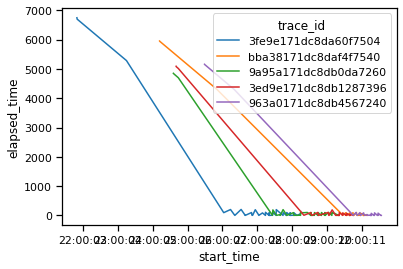

In [ ]:
# Plot the elapsed_time of top traces over the time (around the timestamp of anomaly)
trace1 = trace_df[trace_df['trace_id'].isin(d['trace_id'].iloc[:5])]
trace1['trace_id'] = trace1['trace_id'].astype(str)
sns.lineplot(data=trace1, x='start_time', y='elapsed_time', hue='trace_id')

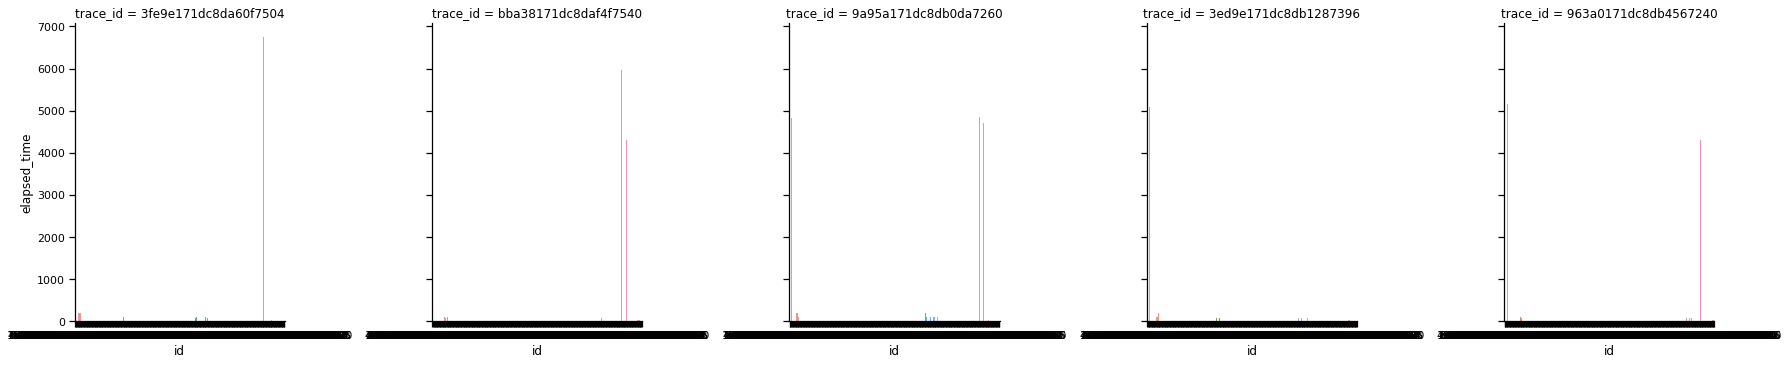

In [ ]:
sns.catplot(data=trace1, x='id', y='elapsed_time', col='trace_id', kind='bar')

TODO: take the failed trace (success=False), the sources of problem should be the sub components that failed. You need to take a leaf spans that failed. Unless it's a node that failed even though its children have successfully completed.


['csf_001']
['csf_001']
['csf_002' 'csf_003' 'csf_004' 'csf_005' 'fly_remote_001'
 'local_method_001' 'local_method_002' 'local_method_003'
 'local_method_004' 'local_method_005' 'local_method_006'
 'local_method_007' 'local_method_009' 'local_method_010']
['csf_002']
['csf_003']
['csf_004']
['csf_005']
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]
[nan]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['local_method_011']
['local_method_013' 'local_method_014']


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


['local_method_015' 'local_method_016']
['local_method_017']


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


[nan]
[nan]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


[nan]
[nan]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


[nan]
[nan]


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


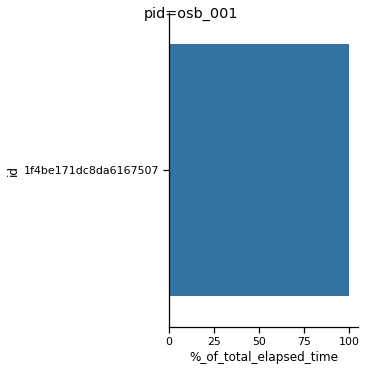

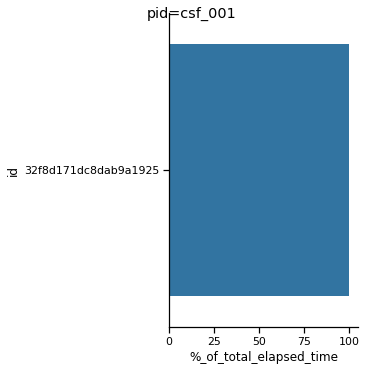

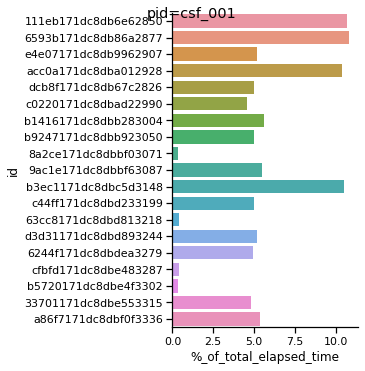

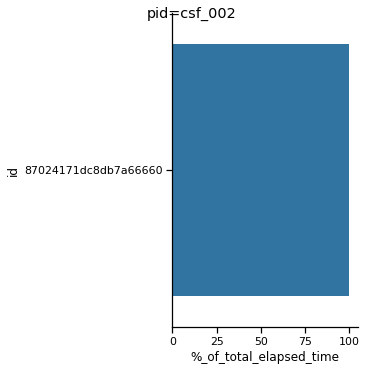

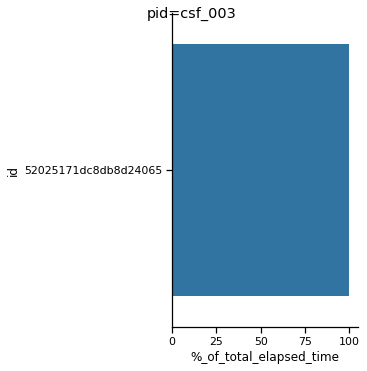

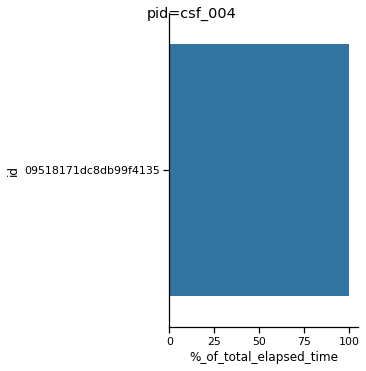

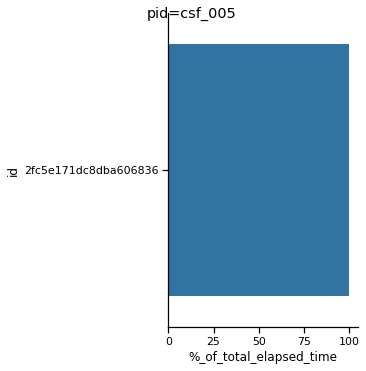

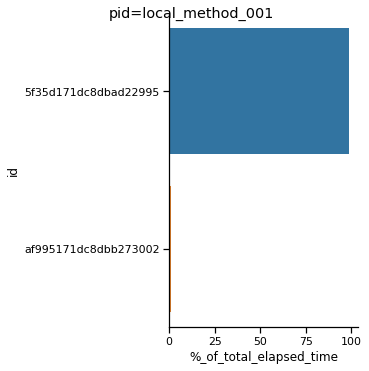

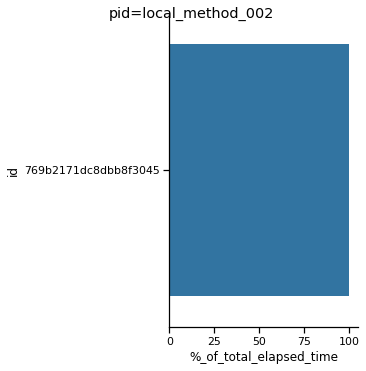

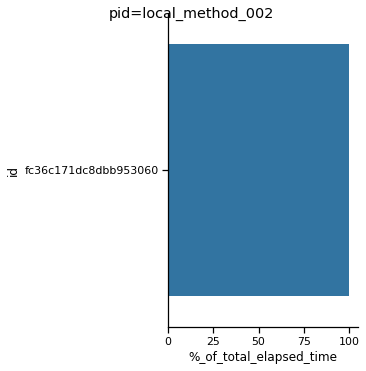

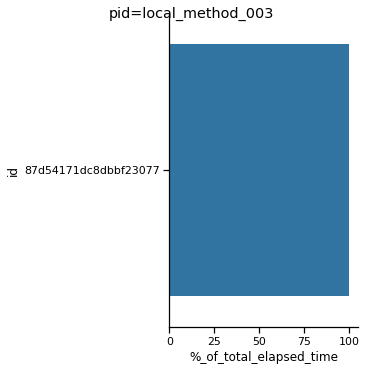

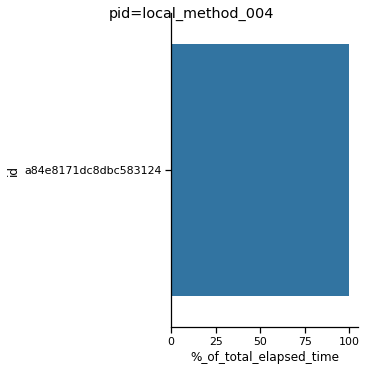

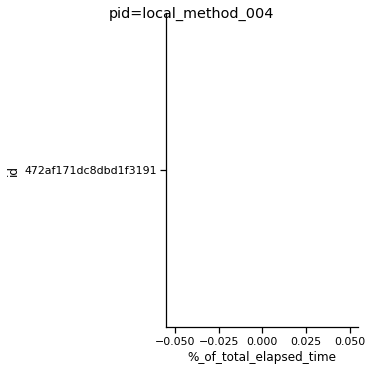

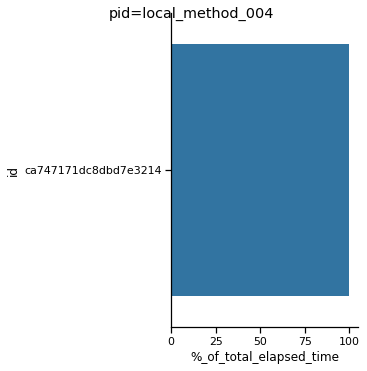

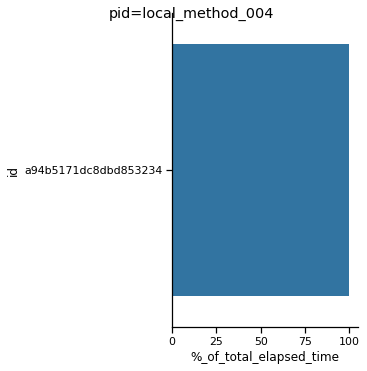

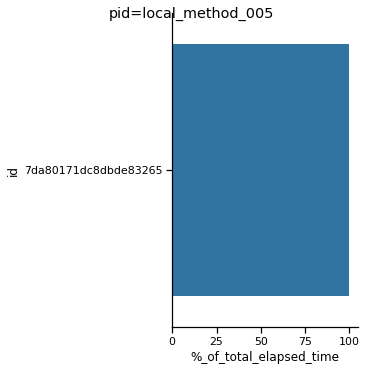

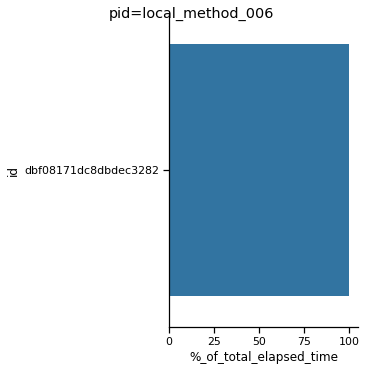

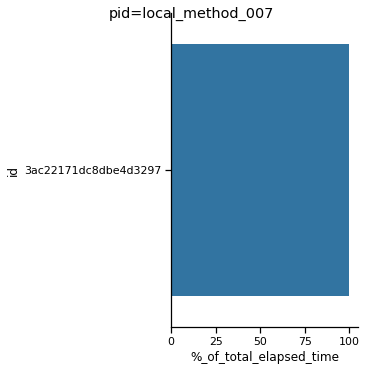

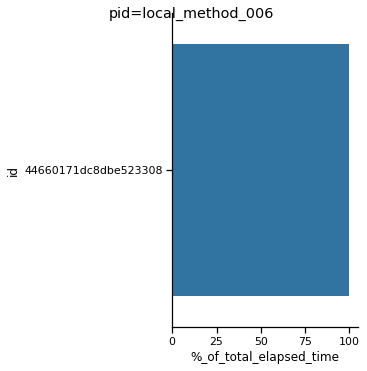

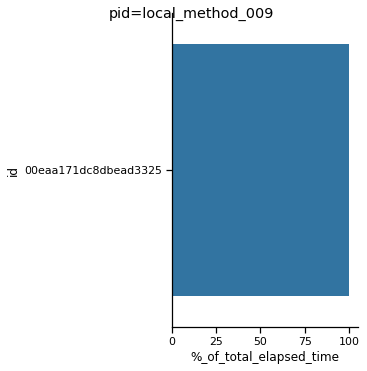

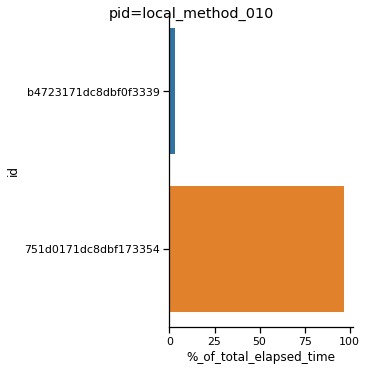

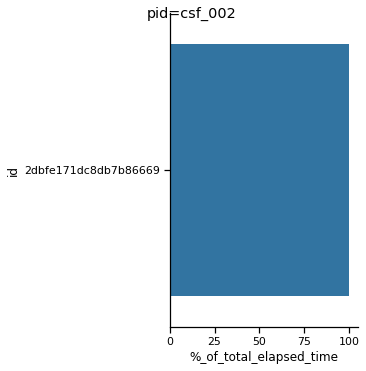

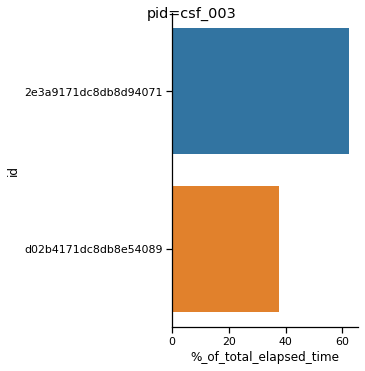

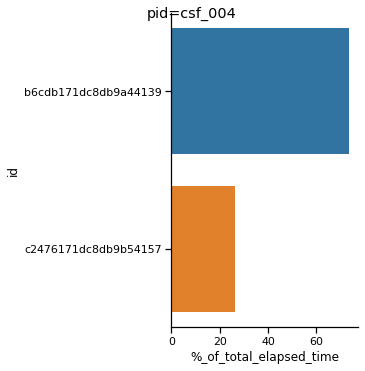

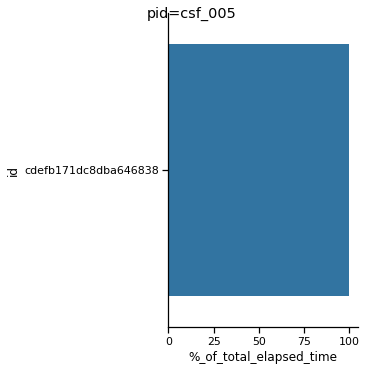

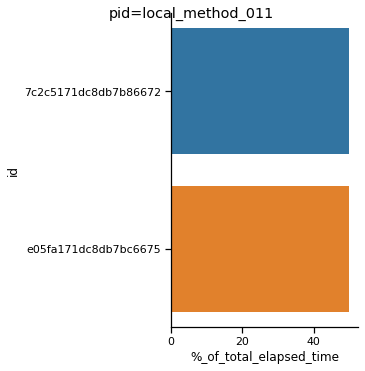

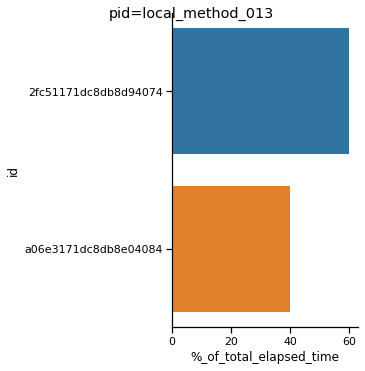

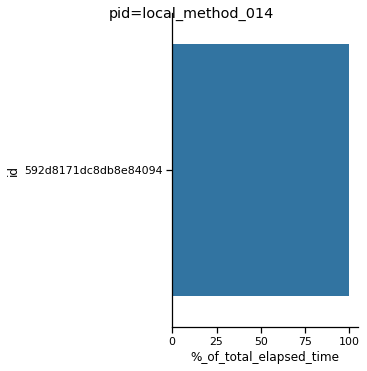

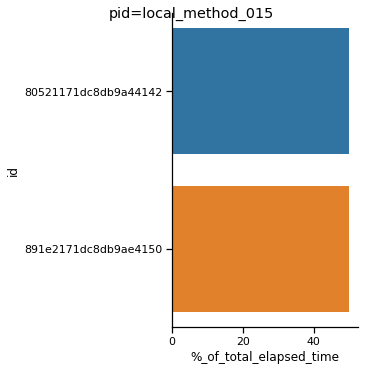

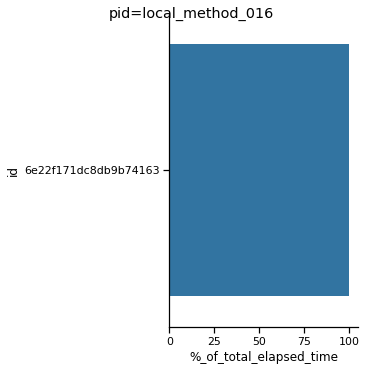

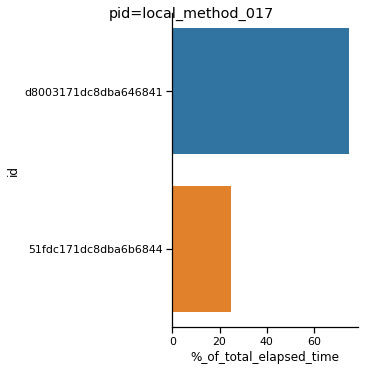

In [ ]:
slowest_trace = trace_df[trace_df['trace_id'] == d['trace_id'].iloc[0]]
parent_id = slowest_trace[slowest_trace['pid'] == 'None']['id'].values[0]
queue = [[parent_id]]

while len(queue) > 0:
  pids = queue.pop()
  q = []
  for pid in pids:
    t = slowest_trace[slowest_trace['pid'] == pid][['pid', 'id', 'elapsed_time', 'service_name']]
    if not t.empty: # if not empty
      t['%_of_total_elapsed_time'] = 100*(t['elapsed_time']/t['elapsed_time'].sum()) # normalize [0, 1]
      if float('nan') in t['service_name'].unique():
        g = sns.catplot(data=t, y='service_name', x='%_of_total_elapsed_time', kind='bar', orient='h')
        g.fig.suptitle('pid={}'.format(slowest_trace[slowest_trace['id'] == pid]['service_name'].values[0]))
        q += slowest_trace[slowest_trace['pid'] == pid]['id'].values.tolist() # add childrens to queue
      else :
        g = sns.catplot(data=t, y='id', x='%_of_total_elapsed_time', kind='bar', orient='h')
        g.fig.suptitle('pid={}'.format(slowest_trace[slowest_trace['id'] == pid]['service_name'].values[0]))
        q += slowest_trace[slowest_trace['pid'] == pid]['id'].values.tolist() # add childrens to queue
  if len(q) > 0 :
    queue.append(q)


# Root cause

## Root cause - simple 
using the timestamp found in the other notebook (anomaly detection in esb), we try to find the root cause of the anomaly. To do so, we first analyze the trace and select the slowest ones. Then we select the nodes that might be the source of the issue (we simply take the common nodes of the slowest traces). Finally, we try to identify the kpi that is anomalous by using a simple hbos model. 

In [ ]:
# get 10 slowest traces
# get the associated nodes
# see which are common to all 10 slowest traces

n_slowest = 5     # retrieve the slowest n traces

# select root of traces that starts in the time interval [anomaly -1min; anomaly +1min]
d = trace_df[(trace_df['pid'] == 'None') & (abs(timestamp_of_first_detected_anomaly - trace_df['start_time']) < datetime.timedelta(minutes=1))]
d = d[['elapsed_time', 'trace_id']]

# sort traces by elapsed time (in first position, the largest elapsed_time because it's most likely this one that causes problem)
d = d.sort_values(by='elapsed_time', ascending=False)

# 5 slowest traces
slowest_traces = trace_df[trace_df['trace_id'].isin(d['trace_id'].iloc[:n_slowest])]
slowest_traces = slowest_traces[['cmdb_id', 'trace_id']]

# get common nodes
common_nodes = slowest_traces['cmdb_id'].unique()
for tid in slowest_traces['trace_id'].values:
  nodes = slowest_traces[slowest_traces['trace_id'] == tid]['cmdb_id']
  common_nodes = common_nodes[np.isin(element=common_nodes, test_elements=nodes)]
print("I've retrived the common nodes of the slowest {} traces : {}".format(n_slowest, common_nodes))

I've retrived the common nodes of the slowest 5 traces : ['os_022' 'docker_001' 'docker_008']


I've created plots of every kpi (37) over time for the given common nodes (before the timestamp of anomaly)


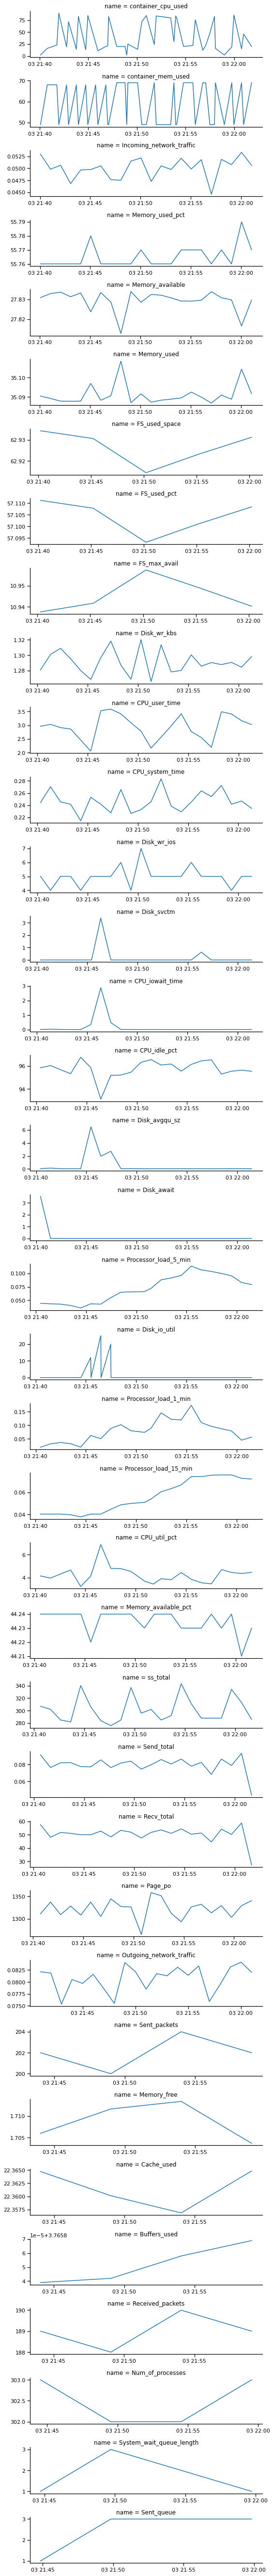

In [ ]:
# get the associated host_kpi_df (time interval = [T-20min, T+2min])
h = host_df[(host_df['cmdb_id'].isin(common_nodes)) & (timestamp_of_first_detected_anomaly - host_df['timestamp'] < datetime.timedelta(minutes=20)) & (host_df['timestamp'] - timestamp_of_first_detected_anomaly < datetime.timedelta(minutes=2))]
h = h[['cmdb_id', 'name', 'bomc_id', 'value', 'timestamp']]
h = h[h.groupby('name')['value'].transform('std') > 0] # remove flat plots (because they obviously are not the anomaly since it doesn't change)

print("I've created plots of every kpi ({}) over time for the given common nodes (before the timestamp of anomaly)".format(h['name'].unique().shape[0]))
g = sns.FacetGrid(data=h, row='name', sharex=False, sharey=False, height=2, aspect=4)
g.map_dataframe(sns.lineplot, x='timestamp', y='value')

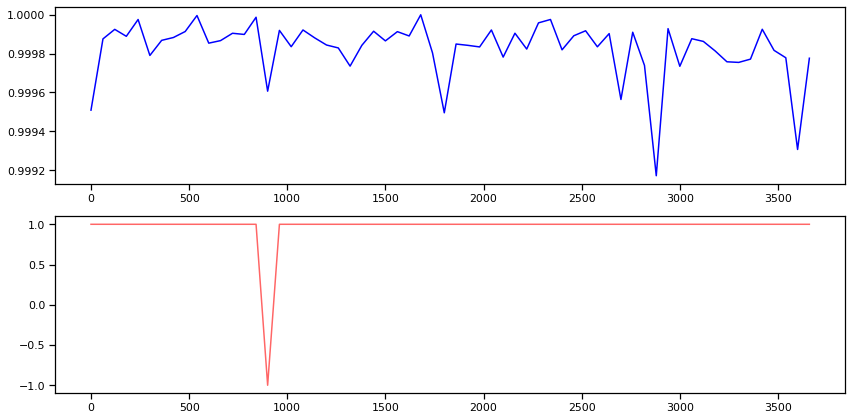

In [ ]:
# Apply an anomaly detection model to each kpi and check if their behavior for the current time interval is anomalous
# below, we are implementing the simple hbos
# !pip install kenchi
from kenchi.outlier_detection.statistical import HBOS
from sklearn.model_selection import train_test_split


# First, train hbos model
_name = 'Memory_available'
X = host_df[(host_df['cmdb_id'].isin(common_nodes)) & (timestamp_of_first_detected_anomaly - host_df['timestamp'] < datetime.timedelta(minutes=60)) & (host_df['timestamp'] - timestamp_of_first_detected_anomaly < datetime.timedelta(minutes=2))]
# X = h[h['name'] == _name][['timestamp', 'value']]
X = X[X['name'] == _name][['timestamp', 'value']]
X['value'] = X['value']/X['value'].max() # normalize values
start = X['timestamp'].min()

X['timestamp'] = (X['timestamp'] - start) / datetime.timedelta(seconds=1)
# x_train = X[X['timestamp'] < (timestamp_of_first_detected_anomaly-start) / datetime.timedelta(seconds=1)]
x_train = X

hbos = HBOS(contamination=0.01, novelty=True).fit(x_train)
y_pred = hbos.predict(x_train)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), tight_layout=True)
ax[0].plot(x_train['timestamp'], x_train['value'], 'b', label='real')
ax[1].plot(x_train['timestamp'], y_pred, 'r', alpha=.6, label='anomaly')

## Moving correlation

In [ ]:
# see https://colab.research.google.com/drive/1u-bsNaXRMo09qllFywRCmVeAIs5U9kdz#scrollTo=uVpni70IfPpV&line=5&uniqifier=1
# get the associated host_kpi_df (time interval = [T-20min, T+2min]) 
h = host_df[(host_df['cmdb_id'].isin(common_nodes)) & (timestamp_of_first_detected_anomaly - host_df['timestamp'] < datetime.timedelta(minutes=20)) & (host_df['timestamp'] - timestamp_of_first_detected_anomaly < datetime.timedelta(minutes=2))]
h = h[['cmdb_id', 'name', 'bomc_id', 'value', 'timestamp']]
h = h[h.groupby('name')['value'].transform('std') > 0] # remove flat plots (because they obviously are not the anomaly since it doesn't change)
h = h.set_index('timestamp').sort_index()

# get esb['avg_time'] corresponding to the same time interval
e = esb_df[(timestamp_of_first_detected_anomaly - esb_df['start_time'] < datetime.timedelta(minutes=20)) & (esb_df['start_time'] - timestamp_of_first_detected_anomaly < datetime.timedelta(minutes=2))]
e = e[['start_time', 'avg_time']]
e = e.set_index('start_time').sort_index()

# # merge those 2 dataframe on start_time and timestamp
merged_df = pd.merge_asof(h, e, right_on='start_time', left_on='timestamp', tolerance=datetime.timedelta(seconds=1))
merged_df['avg_time'] = merged_df['avg_time'].fillna(method='ffill') # fill nan values in avg_time series with previous value (ordered by timestamp)

# compute correlation with esb['avg_time'] of each kpi
abs_correlations_sorted = merged_df.groupby('name').corrwith(merged_df['avg_time']).abs().sort_values('value', ascending=False)
print("I found that the 2 kpi most susceptible of being the cause of the anomaly are {}".format(abs_correlations_sorted.iloc[:2].reset_index()['name'].tolist()))
abs_correlations_sorted

I found that the 2 kpi most susceptible of being the cause of the anomaly are ['Sent_queue', 'Num_of_processes']


,value,avg_time
name,,
Sent_queue,0.891552,1.0
Num_of_processes,0.879645,1.0
System_wait_queue_length,0.827001,1.0
Cache_used,0.795303,1.0
Memory_free,0.741702,1.0
FS_max_avail,0.721418,1.0
FS_used_pct,0.690864,1.0
FS_used_space,0.688686,1.0
Memory_used_pct,0.634085,1.0
